In [8]:
import os
import sys
import pickle
import numpy as np
import pandas as pd
from PIL import Image

from pathlib import Path

project_root = Path(os.path.abspath('')).parent.parent
sys.path.append(str(project_root))


from dotenv import load_dotenv 
load_dotenv()

NIH_CXR14_DATASET_DIR = os.getenv("NIH_CXR14_DATASET_DIR")
INTERMEDIATE_DATA_DIR = project_root / "data"
print(NIH_CXR14_DATASET_DIR)
print(INTERMEDIATE_DATA_DIR)



/home/yasin/Lfstorage/datasets/nih-cxr14/original
/home/yasin/Lfstorage/Projects/cxr-diffusion/data


In [9]:
import torch
from torch.utils.data import Dataset
import torch.optim as optim
from diffusers import DDPMScheduler, UNet2DConditionModel


In [10]:
class Diffusion():
    def __init__(self, model, scheduler, processor,num_inference_step=50):
        self.model = model
        self.scheduler = scheduler
        self.processor = processor
        self.num_inference_step = num_inference_step
        self.device = next(model.parameters()).device

    def generate(self, cond_embed, latent):
        if latent is None:
            generator = torch.Generator(device=self.device).manual_seed(np.random.randint(0, 1000000))
            latent = torch.randn((1,4,64,64), device = self.device, generator=generator)
        self.scheduler.set_timesteps(self.num_inference_step)
        timesteps = self.scheduler.timesteps

        cond_embed = cond_embed.to(self.device)

        with torch.no_grad():
            for t in timesteps:
                latent_model_input = latent
                latent_model_input = self.scheduler.scale_model_input(latent_model_input, t)
                noise_pred = self.model(
                    latent_model_input,
                    t,
                    encoder_hidden_states=cond_embed
                ).sample

                latent = self.scheduler.step(noise_pred, t, latent).prev_sample
            
            image = self.processor.decode_latent(latent)[0]
        return image
        

In [11]:
def prepare_cond_input(embeddings, padding=True):
    if isinstance(embeddings, np.ndarray):
        embeddings = torch.tensor(embeddings)
    if padding:
        padding_size = 77 - embeddings.shape[0]
        padding = torch.zeros((padding_size, embeddings.shape[1]))
        embeddings = torch.cat((embeddings, padding), dim=0)

        #add batch dimension
        embeddings = embeddings.unsqueeze(0)
    return embeddings

def prepare_latent_input(image,processor):
    image = processor.encode_image(image)
    return image

def decode_latent(image, processor):
    return processor.decode_latent(image)


In [12]:
from matplotlib import pyplot as plt


def show_grid(images, images_titles, rows, main_title=None):
    cols = len(images) // rows

    # Adjust figsize based on the number of rows
    if rows == 1:
        fig, axs = plt.subplots(rows, cols, figsize=(cols * 2, 2.5))  # Adjusted height
    else:
        fig, axs = plt.subplots(rows, cols, figsize=(10, 10))

    if main_title:
        fig.suptitle(main_title, fontsize=16)

    if rows == 1:  # Handle 1-row case
        for i, (image, title) in enumerate(zip(images, images_titles)):
            axs[i].imshow(image, cmap="gray")
            axs[i].axis("off")
            axs[i].set_title(title, fontsize=8, pad=5)  # Add padding
    else:  # Handle multi-row case
        for i, (image, title) in enumerate(zip(images, images_titles)):
            ax = axs[i // cols, i % cols]
            ax.imshow(image, cmap="gray")
            ax.axis("off")
            ax.set_title(title, fontsize=8, pad=5) # Add padding

    plt.tight_layout(pad=1.5) #Add padding to tight_layout
    return fig

In [50]:
clip_vision_embeddings_path = INTERMEDIATE_DATA_DIR / "clip_vision_embeddings.pkl"

filtered_nihcxr14 = pd.read_csv(INTERMEDIATE_DATA_DIR / "filtered_nihcxr14.csv")
img_idxs = filtered_nihcxr14["Image Index"].tolist()
unet_model_path = "./output/best/"

In [51]:
from src.pipelines import VaeProcessor
from src.datasets import NIHImageDataset

dataset = NIHImageDataset(NIH_CXR14_DATASET_DIR)


with open(clip_vision_embeddings_path, "rb") as f:
    clip_vision_embeddings = pickle.load(f)




dataset = dataset.filter_by_id(img_idxs)






In [52]:
len(img_idxs)

48311

In [53]:
random_sample = np.random.choice(len(dataset), 24)


idxs = [img_idxs[i] for i in random_sample]

images = []
for idx in idxs:
    _, image = dataset[idx]
    images.append(image)

clip_vision_embeddings = [clip_vision_embeddings[idx] for idx in idxs]
clip_vision_embeddings = np.array(clip_vision_embeddings)

In [54]:
idxs

['00028291_000.png',
 '00002747_000.png',
 '00013669_000.png',
 '00021383_005.png',
 '00020791_000.png',
 '00013424_002.png',
 '00018669_005.png',
 '00006926_010.png',
 '00017110_022.png',
 '00018363_002.png',
 '00023296_011.png',
 '00001373_025.png',
 '00020673_008.png',
 '00022401_001.png',
 '00026099_033.png',
 '00008745_035.png',
 '00019065_008.png',
 '00007551_006.png',
 '00023146_005.png',
 '00003412_000.png',
 '00005224_001.png',
 '00002491_000.png',
 '00018308_003.png',
 '00028458_001.png']

In [55]:
clip_vision_embeddings[0]

array([-8.19982886e-01,  9.98440981e-01,  2.10951895e-01,  3.20811540e-01,
       -1.32151425e-01,  3.71558577e-01, -5.69058597e-01,  6.35007381e-01,
       -2.49176472e-02, -1.29113460e+00, -3.73379767e-01, -3.26655537e-01,
       -8.03963304e-01, -6.74264431e-02,  1.05883852e-01,  5.20719945e-01,
       -5.26399016e-01, -1.14784300e-01, -5.87103441e-02, -2.83897310e-01,
        6.55414581e-01, -1.49901360e-01, -3.58097076e-01,  7.54226208e-01,
       -9.69115257e-01,  3.16797942e-01,  5.00374615e-01, -2.30891183e-02,
        5.04070640e-01, -6.07963502e-02,  5.61304271e-01, -4.79129285e-01,
       -7.76137471e-01, -2.61318117e-01,  6.29288629e-02, -4.20607924e-02,
        5.17477572e-01, -8.23623985e-02, -1.14065990e-01, -2.87793577e-03,
        5.73585033e-01,  4.11059320e-01, -4.55173627e-02, -2.53181964e-01,
       -7.90942758e-02,  1.62576795e-01, -2.78924435e-01, -1.26169264e-01,
        1.25149935e-02, -3.78563493e-01, -7.68567741e-01,  6.47771060e-02,
       -4.23535734e-01,  

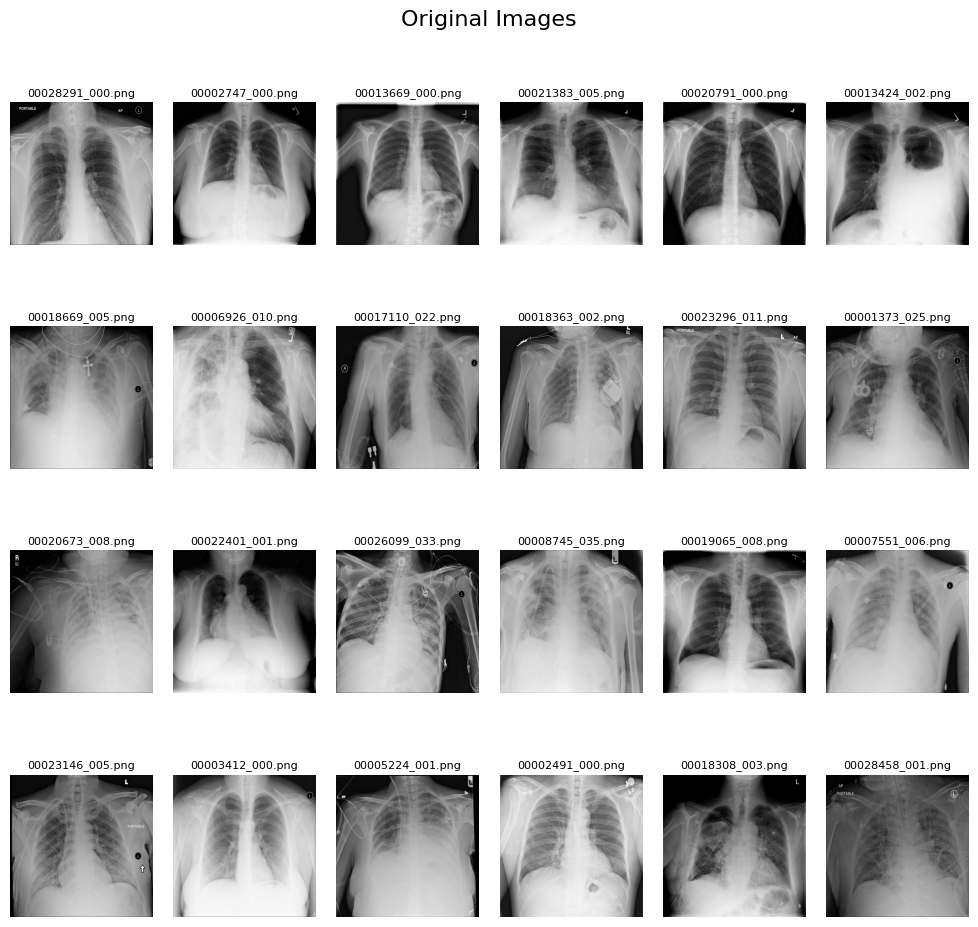

In [56]:
gray_images = [image.convert("L") for image in images]

fig = show_grid(gray_images, idxs, 4, "Original Images")

fig.show()

In [57]:
device = "cuda:2"
num_inference_step = 50


In [58]:
unet = UNet2DConditionModel().from_pretrained(unet_model_path)
unet.to(device)

processor = VaeProcessor(device=device)

scheduler = DDPMScheduler()

In [59]:
diffusion= Diffusion(unet, scheduler, processor, num_inference_step=num_inference_step)


In [60]:
generated_images = []
for clip_vision_embedding in clip_vision_embeddings:
    cond_input = prepare_cond_input(clip_vision_embeddings, padding=False)
    cond_input = cond_input.unsqueeze(0)
    image = diffusion.generate(cond_input, None)
    generated_images.append(image)

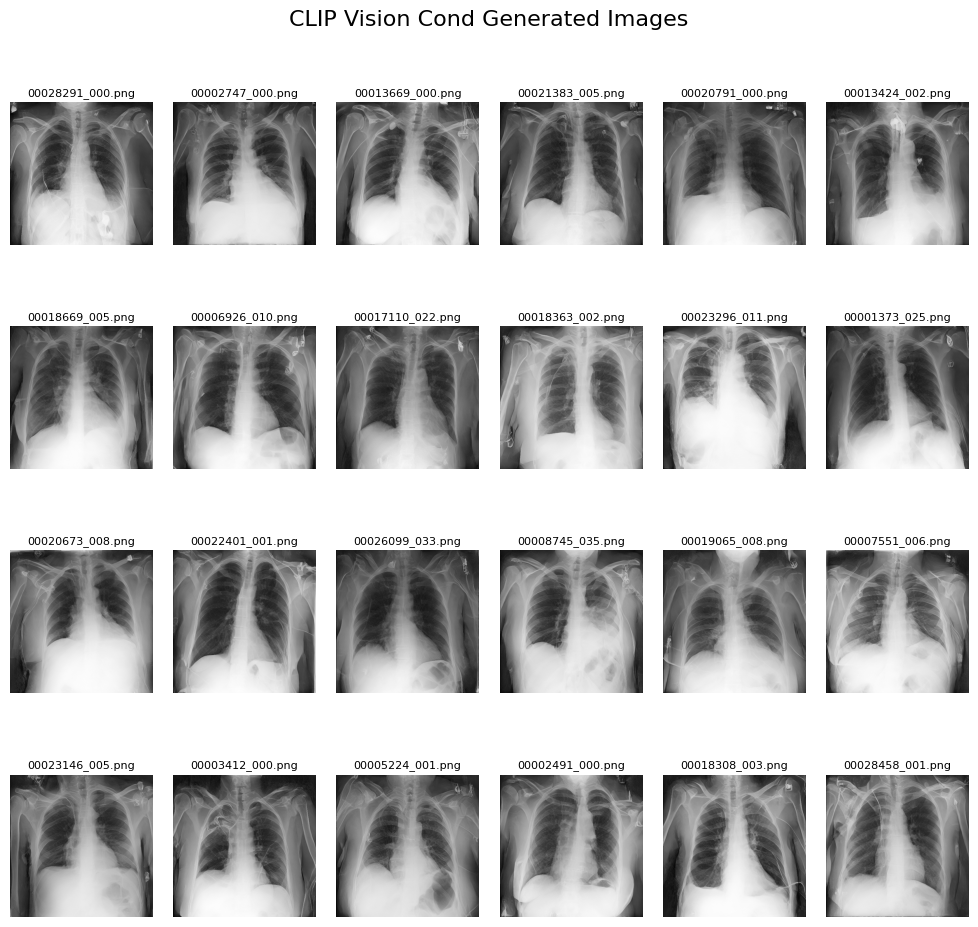

In [61]:
generated_gray_images = [image.convert("L") for image in generated_images]

fig = show_grid(generated_gray_images, idxs, 4, "CLIP Vision Cond Generated Images")

fig.show()

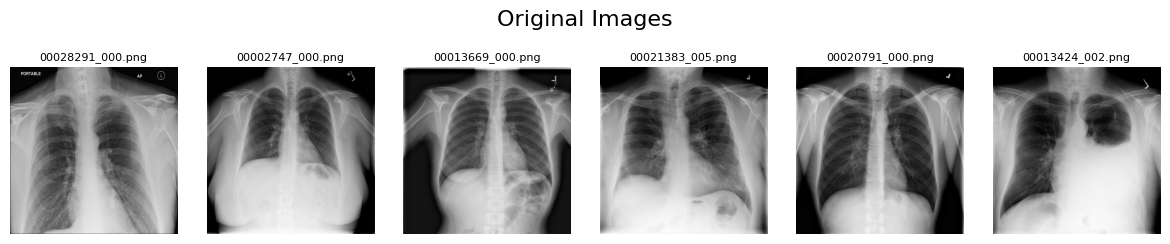

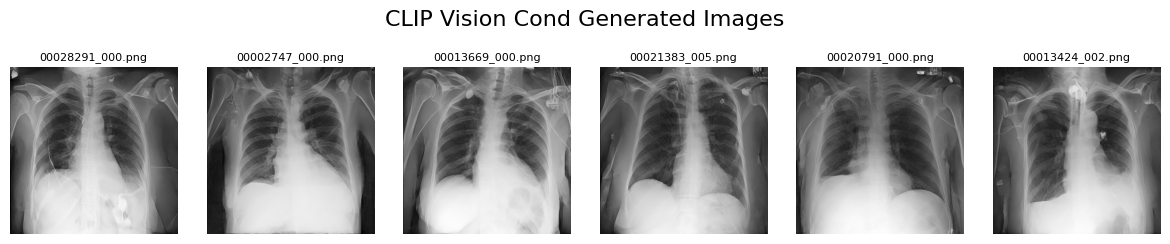

In [62]:
six_sample_idxs = idxs[:6]
six_sample_gray_images = gray_images[:6]
six_sample_generated_gray_images = generated_gray_images[:6]

fig_original = show_grid(six_sample_gray_images, six_sample_idxs, 1, "Original Images")
fig_generated = show_grid(six_sample_generated_gray_images, six_sample_idxs, 1, "CLIP Vision Cond Generated Images")
